In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGenV2, AffineGridGen, DenseAffine3DGridGen, DenseAffine3DGridGen_rotate, Depth3DGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
cgen = Depth3DGridGen(64, 128).cuda()

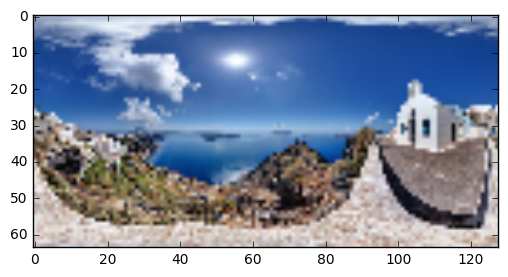

In [3]:
from PIL import ImageFilter
img = Image.open('equi.png').convert('RGB').resize((128,64))
img = np.array(img)/255.0
plt.imshow(img)

In [4]:
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0)))

In [5]:
st = STN()

In [6]:
rotate = Variable(torch.from_numpy(np.array([[0.6]]).astype(np.float32))).cuda()
trans0 = Variable(torch.from_numpy(np.array([[0.5]]).astype(np.float32))).cuda()
trans1 =  Variable(torch.from_numpy(np.array([[0.4]]).astype(np.float32))).cuda()
print(rotate)

Variable containing:
 0.6000
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]



In [10]:
depth = Variable(torch.ones(1,64,128,1), requires_grad = True).cuda()

In [12]:
out = cgen(depth, trans0, trans1, rotate)

In [13]:
out.size()

torch.Size([1, 64, 128, 2])

In [15]:
out.backward(torch.rand(1,64,128,2).cuda())

In [17]:
imgout = st(input1, out.cpu())

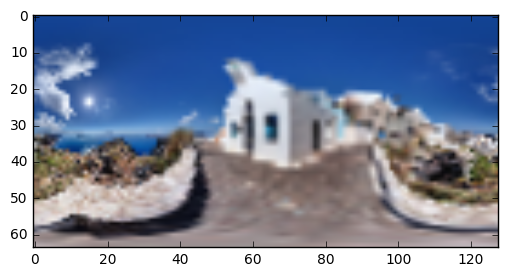

In [18]:
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [22]:
grid_data = out.cpu().data.numpy()[0]

In [23]:
delta = 0.025
x = np.arange(-1, 1, 2/128.0)
y = np.arange(-1, 1, 2/64.0)
X, Y = np.meshgrid(x, y)
Z1 = grid_data[:,:,0]
Z2 = grid_data[:,:,1]

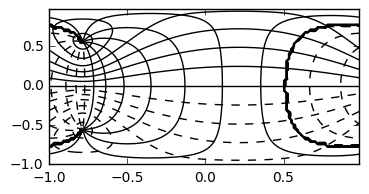

In [24]:
fig = plt.figure(figsize=(4,2))
CS = plt.contour(X, Y, Z1, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)